# Project Final Report - Who contributes the most data?

Authors: Hunter, Sophia, Jiho, and Freya

## Introduction (write in Introduction.md first)

#### Background Information

...

#### The Question

...

#### The Data

...

## Methods & Results

#### Loading the Data

First, we must load in the nessary libaries for working with data frames, resizing graphs, and working with predictive models respectivley.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(caret)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then, we download the player data and read it into R.

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=18CyKdv1ppgp7RraugrDq66w_T-6dkrdG"

download.file(players_url, "players.csv")

players <- read_csv("players.csv")

glimpse(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…


#### Wrangling the Data

We will need to convert the columns to their proper types, so experience will be a factor, Age is an integer, ect. We also want to remove any rows with NA values, which in this case happens to only be in the Age column.

In [3]:
players <- mutate(players,
    experience = as_factor(experience),
    gender = as_factor(gender)) |>
    filter(!is.na(Age))


players <- players |> 
    select(Age, experience, 
           subscribe, played_hours)

glimpse(players)

Rows: 194
Columns: 4
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…
$ experience   <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, Regular…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…


Now we split the data into our training and testing sets. We will only use the training data for our visualizations and analysis.

In [4]:
set.seed(123)
players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

Next, we have to encode the data properly so that the model can interpret it. Both the experience and subscribe variables are currently in the wrong format. We will use one hot coding to fix the experience variable and a simple mutation to transform the subsribe variable.

In [5]:
players_train_encoded <- dummyVars("~ experience", data = players_train) |>
    predict(newdata = players_train) |>
    as.data.frame() |>
    bind_cols(players_train) |>
    select(-experience)

players_train_encoded <- mutate(players_train_encoded,
    subscribe_encoded = ifelse(subscribe == TRUE, 1, 0)) |>
    select(-subscribe)

players_test_encoded <- dummyVars("~ experience", data = players_test) |>
    predict(newdata = players_test) |>
    as.data.frame() |>
    bind_cols(players_test) |>
    select(-experience)

players_test_encoded <- mutate(players_test_encoded,
    subscribe_encoded = ifelse(subscribe == TRUE, 1, 0)) |>
    select(-subscribe)


glimpse(players_train_encoded)
glimpse(players_test_encoded)

Rows: 145
Columns: 8
$ experience.Pro      <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ experience.Veteran  <dbl> 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,…
$ experience.Amateur  <dbl> 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,…
$ experience.Regular  <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,…
$ experience.Beginner <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,…
$ Age                 <dbl> 19, 21, 17, 22, 17, 17, 17, 17, 17, 23, 18, 23, 17…
$ played_hours        <dbl> 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, …
$ subscribe_encoded   <dbl> 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,…
Rows: 49
Columns: 8
$ experience.Pro      <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ experience.Veteran  <dbl> 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,…
$ experience.Amateur  <dbl> 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,…
$ experience.Regular  <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,…

[description of methods]

In [6]:
experience_averages <- players_train |>
    group_by(experience) |>
    summarize(average_played_hours = mean(played_hours, na.rm = TRUE))

experience_averages

experience,average_played_hours
<fct>,<dbl>
Pro,0.4000000
Veteran,0.7805556
Amateur,4.7500000
Regular,18.8875000
Beginner,0.6037037


In order to understand how subscription status plays a role in played_hours we group the data into average played_hours according to subscription.

In [7]:
subscribe_averages <- players_train |>
    group_by(subscribe) |>
    summarize(mean_played_hours = mean(played_hours))

subscribe_averages

subscribe,mean_played_hours
<lgl>,<dbl>
FALSE,0.570000
TRUE,6.732381


Here we grouped the age data into different categories to better understand which age groups were more likey to have a larger played_hours value.

In [8]:
selected_hours_age <- players_train |>
    select(Age, played_hours) |>
    filter(!is.na(Age) & !is.na(played_hours))

mutated_hours_age = mutate(selected_hours_age,
    age_category = as_factor(ifelse(Age < 8, "<8",
                ifelse(Age >= 8 & Age <= 12, "8-12",
                ifelse(Age >= 13 & Age <= 17, "13-17",
                ifelse(Age >= 18 & Age <= 22, "18-22",
                ifelse(Age >= 23 & Age <= 26, "22-26",
                ifelse(Age >= 27 & Age <= 30, "26-30", "30+"))))))))

grouped_hours_age <- mutated_hours_age |>
    group_by(age_category) |>
    summarize(average_played_hours = mean(played_hours))

grouped_hours_age$age_category <- factor(grouped_hours_age$age_category, 
    levels = c("<8", "8-12", "13-17","18-22", "22-26", "26-30","30+"))


grouped_hours_age

age_category,average_played_hours
<fct>,<dbl>
18-22,6.4761905
13-17,5.4588235
22-26,3.0590909
26-30,3.3250000
30+,0.3666667
8-12,1.2333333


#### Summary of Dataset

Since we are concerned with experience, subscribe, age, and played_hours for our model, let's make some tables of summary statistics for the counts/measures of center of those variables.

In [9]:
summarize(players, 
    average_played_hours = mean(played_hours),
    median_played_hours = median(played_hours),
    average_age = mean(Age),
    median_age = median(Age))

summarize(group_by(players, experience), count = n())

summarize(group_by(players, subscribe), count = n())


average_played_hours,median_played_hours,average_age,median_age
<dbl>,<dbl>,<dbl>,<dbl>
5.904639,0.1,20.52062,19


experience,count
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,142


[additional summary]

#### Visualizations

[description of methods]

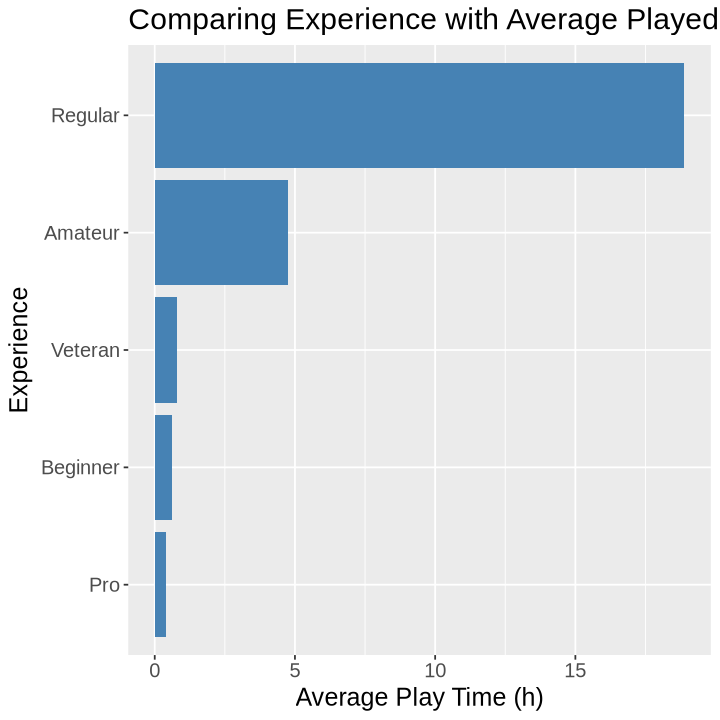

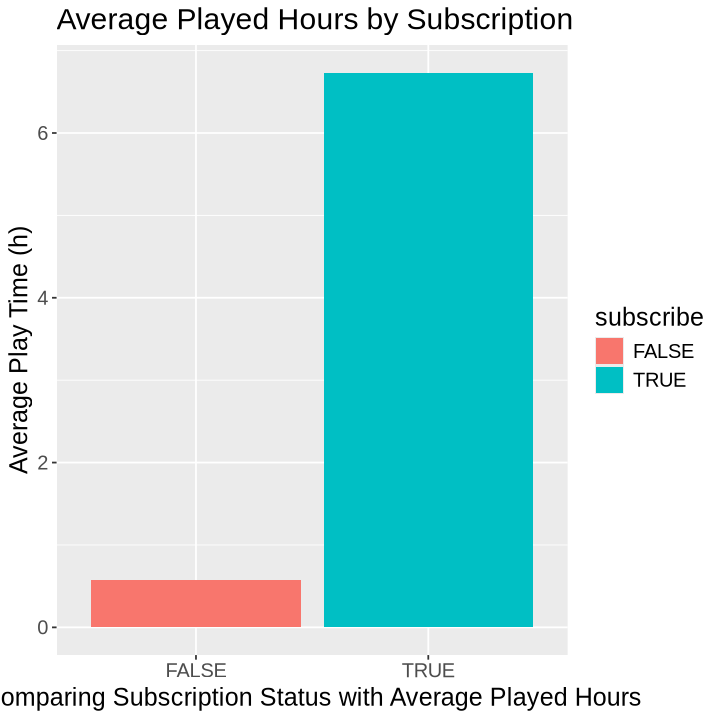

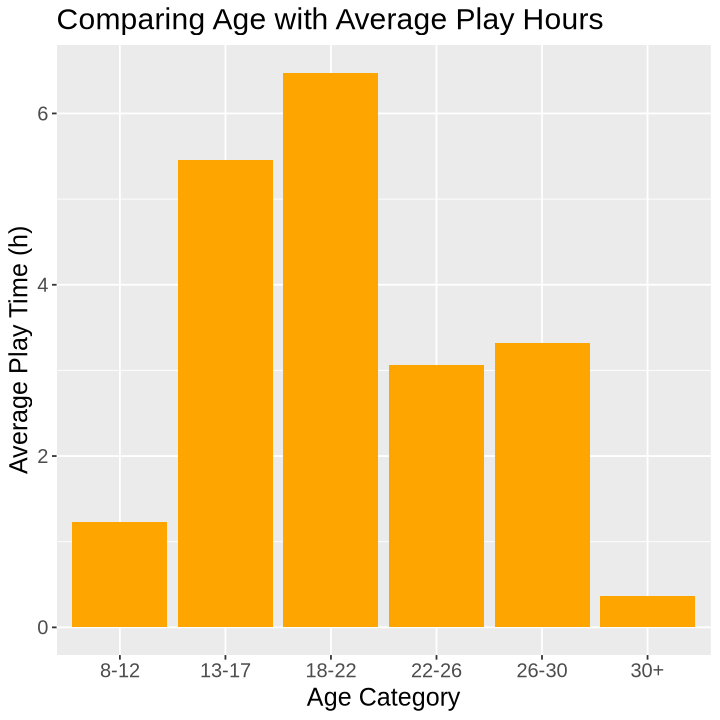

In [10]:
# these visualizations are relevant for exploratory data analysis and related to the planned analysis

options(repr.plot.width = 6, repr.plot.height = 6)

experience_plot <- ggplot(experience_averages, 
                          aes(x = average_played_hours, y = fct_reorder(experience, average_played_hours))) + 
    geom_bar(stat = "identity", fill = "steelblue") + 
    labs(x = "Average Play Time (h)", y = "Experience", 
         title = "Comparing Experience with Average Played Hours") + 
    theme(text = element_text(size = 15))

experience_plot


subscribe_plot <- ggplot(subscribe_averages, 
                          aes(x = subscribe, y = mean_played_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(x = "Comparing Subscription Status with Average Played Hours", y = "Average Play Time (h)", 
           title = "Average Played Hours by Subscription") +
    theme(text = element_text(size = 15))

subscribe_plot

age_plot <- ggplot(grouped_hours_age, aes(x = age_category, y = average_played_hours)) +
    geom_bar(stat = "identity", fill = "orange") + 
    labs(x = "Age Category", y = "Average Play Time (h)", title = "Comparing Age with Average Play Hours") + 
    theme(text = element_text(size = 15))

age_plot
# note: all figures should have a figure number and a legend

#### Modeling and Analysis

[description of methods]

[1] 145

neighbors,mean
<int>,<dbl>
1,16.789


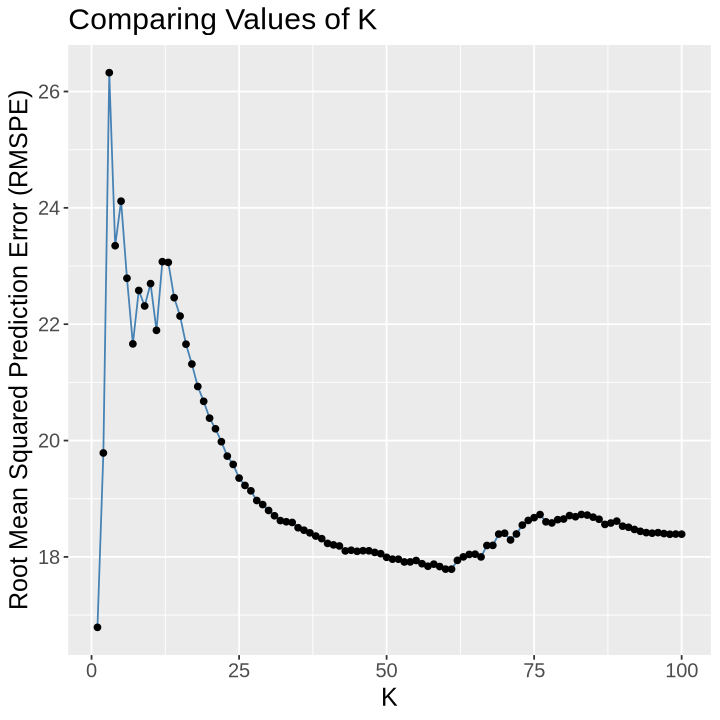

In [11]:
set.seed(123)
# should include visualizations of model
# players_train_encoded <- players_train_encoded |>
#     select(-starts_with("subscribe"))

# players_test_encoded <- players_test_encoded |>
#     select(-starts_with("subscribe"))

nrow(players_train_encoded)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train_encoded, v = 5, strata = played_hours)

knn_recipe <- recipe(played_hours ~ ., data = players_train_encoded) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

k_vals <- tibble(neighbors = 1:100)

knn_metrics <- workflow()|>
    add_recipe(knn_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    select(neighbors, mean)

metric_plot <- ggplot(knn_metrics, aes(x = neighbors, y = mean)) +
    geom_line(color = "steelblue") +
    geom_point() +
    labs(x = "K", y = "Root Mean Squared Prediction Error (RMSPE)", 
         title = "Comparing Values of K") +
    theme(text = element_text(size = 15))

lowest_rmspe <- slice_min(knn_metrics, mean, n = 1)
    

lowest_rmspe

metric_plot

In [12]:
set.seed(123)
kmin <- lowest_rmspe |> pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train_encoded)

test_predictions <- players_fit |>
  predict(players_test_encoded) |>
  bind_cols(players_test_encoded) 

test_predictions_summary <- test_predictions |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

test_predictions_summary
test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,33.88083


,.pred,experience.Pro,experience.Veteran,experience.Amateur,experience.Regular,experience.Beginner,Age,played_hours,subscribe_encoded
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5,1,0,0,0,0,9,30.3,1
2,0.0,0,1,0,0,0,17,0.0,0
3,0.0,0,0,0,1,0,21,0.1,1
4,0.0,0,0,1,0,0,17,0.0,1
5,0.0,0,0,1,0,0,22,0.0,0
6,0.0,0,0,0,0,1,17,0.0,1
7,0.0,0,1,0,0,0,21,0.1,1
8,0.0,0,0,1,0,0,17,0.0,1
9,0.1,0,0,1,0,0,33,0.0,0


## Discussion (write in Discussion.md first)

#### Summary

...

#### Is this what you expected?

...

#### What is the impact of the findings?

...

#### Future Questions

...